In [1]:
!pip install -q segmentation_models_pytorch
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
tqdm.pandas()

import pydicom
import gc
import sys

import numpy as np 
import pandas as pd 
import os
from pathlib import Path
from PIL import Image
from matplotlib.patches import Rectangle

from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from segmentation_models_pytorch import Unet



/home/nova/anaconda3/envs/rsna_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
gc.collect()

16

In [3]:
#transforms
newsize = (256, 256)
#dataset
fold = 1
#dataloader
batch_size = 64
num_workers = 4
#model
num_classes = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#run
epochs = 100
learning_rate = 1e-3

TRAIN = False #or False for inference only

/home/nova/anaconda3/envs/rsna_env/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538621320/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
device

device(type='cpu')

In [5]:
model = Unet(
  encoder_name="resnet34",  # Choose encoder (e.g. resnet18, efficientnet-b0)
  classes=num_classes,  # Number of output classes
  in_channels=3  # Number of input channels (e.g. 3 for RGB)
)

In [6]:
class SEGDataset(Dataset):
    def __init__(self, df, mode, transforms=None):
        self.df = df.reset_index()
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_path = row.image_path
        row_id = row.row_id

        # Open image
        image = pydicom.dcmread(image_path).pixel_array
        image = Image.fromarray(image)
        if image.mode != 'RGB':  # Ensure image is RGB
            image = image.convert('RGB')
        image = np.asarray(image)
        if (image > 1).any():  # Normalize if pixel values are between 0-255
            image = image / 255.0
        mask = np.zeros((image.shape[0], image.shape[1]))
        
        if(self.mode=='train'):
            mask_path = os.path.join(mask_dir, row.image)
            # Open mask
            mask = Image.open(mask_path)
            mask = np.asarray(mask)
            assert mask.max() < num_classes, f"Mask value {mask.max()} exceeds number of classes {num_classes}"

            # Apply transformations
            if self.transforms is not None:
                transformed = self.transforms(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]

            # Create one layer for each label
            mask = torch.as_tensor(mask).long()
            mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).permute(2,0,1).float()
            #mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).permute(0,3,1,2).squeeze(0).float()
        else:
            if self.transforms is not None:
                transformed = self.transforms(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]

    # Create one layer for each label
        mask = torch.as_tensor(mask).long()
        mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).permute(2,0,1).float()
        #mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).permute(0,3,1,2).squeeze(0).float()    
    # Convert image to tensor
        image = torch.as_tensor(image).float()

        return row_id, image, mask 

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms_train = A.Compose([
    A.Resize(newsize[0], newsize[1]),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

transforms_valid = A.Compose([
    A.Resize(newsize[0], newsize[1]),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

In [8]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_ce=1.0, weight_iou=1.0):
        super(CombinedLoss, self).__init__()
        self.weight_ce = weight_ce
        self.weight_iou = weight_iou
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # Cross-Entropy Loss
        ce_loss = self.cross_entropy_loss(inputs, targets)

        # IoU Loss
        # Apply softmax to the inputs to get probabilities
        probs = F.softmax(inputs, dim=1)

        intersection = torch.sum(probs * targets, dim=(2, 3))
        union = torch.sum(probs + targets, dim=(2, 3)) - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_loss = 1 - iou.mean()

        # Combine losses
        loss = self.weight_ce * ce_loss + self.weight_iou * iou_loss
        return loss

In [9]:
criterion = CombinedLoss()
model.to(device)

if TRAIN:
    run(train_loader, val_loader, model, learning_rate, criterion, epochs, device)
else:
    model.load_state_dict(torch.load("/home/nova/Desktop/Nova/Segmentations/rsna-2024-lumbar-spine-degenerative-classification/simple_unet_2d_lspine-pytorch-one-v1/simple_unet.pth", 
                                    map_location=torch.device('cpu')))
                      

/tmp/ipykernel_101923/1858024672.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/nova/Desktop/Nova/Segmentations/rsna-2024-lumbar

In [10]:
import matplotlib.pyplot as plt

def inference(model, dataloader, device, num_samples=16):
    model.eval()
    images_batch = []
    preds_batch = []
    rowId_batch = []
    
    with torch.no_grad():
        print('inference start')
        for row_id, images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            rowId_batch.extend(list(row_id))
            images_batch.append(images.cpu())
            preds_batch.append(preds.cpu())
            
            if len(images_batch) * images.size(0) >= num_samples:
                break
                
    rowId_batch = rowId_batch[:num_samples]
    images_batch = torch.cat(images_batch)[:num_samples]
    preds_batch = torch.cat(preds_batch)[:num_samples]
    
    return rowId_batch, images_batch, preds_batch


# Define a color map with fixed colors for each label
def get_label_colors(num_classes):
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    return colors

label_dict = {1 : '1: L5', 2 : '2: L4', 3 : '3: L3', 4 : '4: L2', 5 : '5: L1', 6 : '6: T12',
                7 : '7: unknown', 8 : '8: unknown', 9 : '9: unknown',
                10: '10: spinal canal', 11: '11: L5-S1', 12: '12: L4-L5', 13: '13: L3-L4',
                14: '14: L2-L3', 15: '15: L1-L2', 16: '16: T12-L1',
                17: '17: unknown', 18: '18: unknown', 19: '19: unknown'
             }
label_list = ['unknown', 'L5', 'L4', 'L3', 'L2', 'L1',
             'T12', 'unknown', 'unknown', 'unknown',
             'spinal_canal', 'L5-S1', 'L4-L5', 'L3-L4',
             'L2-L3', 'L1-L2', 'T12-L1', 'unknown', 'unknown', 'unknown']

def visualize_predictions(images, masks, num_classes=19, num_samples=16):

    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(25, 20))
    
    label_colors = get_label_colors(num_classes)
    
    for i in range(num_samples):
        plt.subplot(4, 8, i * 2 + 1)
        im = images[i].numpy()
        im = np.transpose(im, (1, 2, 0))
        #denormalize
        im = ((im * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]) * 255
        # im = (im * 255).astype(np.uint8)
        plt.imshow(im)
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(4, 8, i * 2 + 2)
        mask = masks[i].numpy()

        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        for label in range(num_classes):
            color_mask[mask == label] = label_colors[label][:3] * 255
        
        plt.imshow(color_mask.astype(np.uint8))
        plt.title("Predicted Mask")
        plt.axis('off')
    ## for legend
    plt.subplot(4, 8, 4*8)
    handles = [Rectangle((0,0),1,1, color=label_colors[i][:3]) for i in range(1, num_classes)]
    labels = list(label_dict.values())
    plt.legend(handles,labels, loc="upper right", fontsize=20)
    plt.axis('off')

    plt.show()

In [11]:
cwd = os.getcwd()
path = cwd + "/train_data.csv"
train_data = pd.read_csv(path)

In [12]:
test = train_data.loc[train_data['series_description'] == 'Sagittal T2/STIR'].reset_index(drop=True)

dataset_valid = SEGDataset(test, 'valid',  transforms_valid)

val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=25, shuffle=False, num_workers=num_workers, pin_memory=False)

inference start


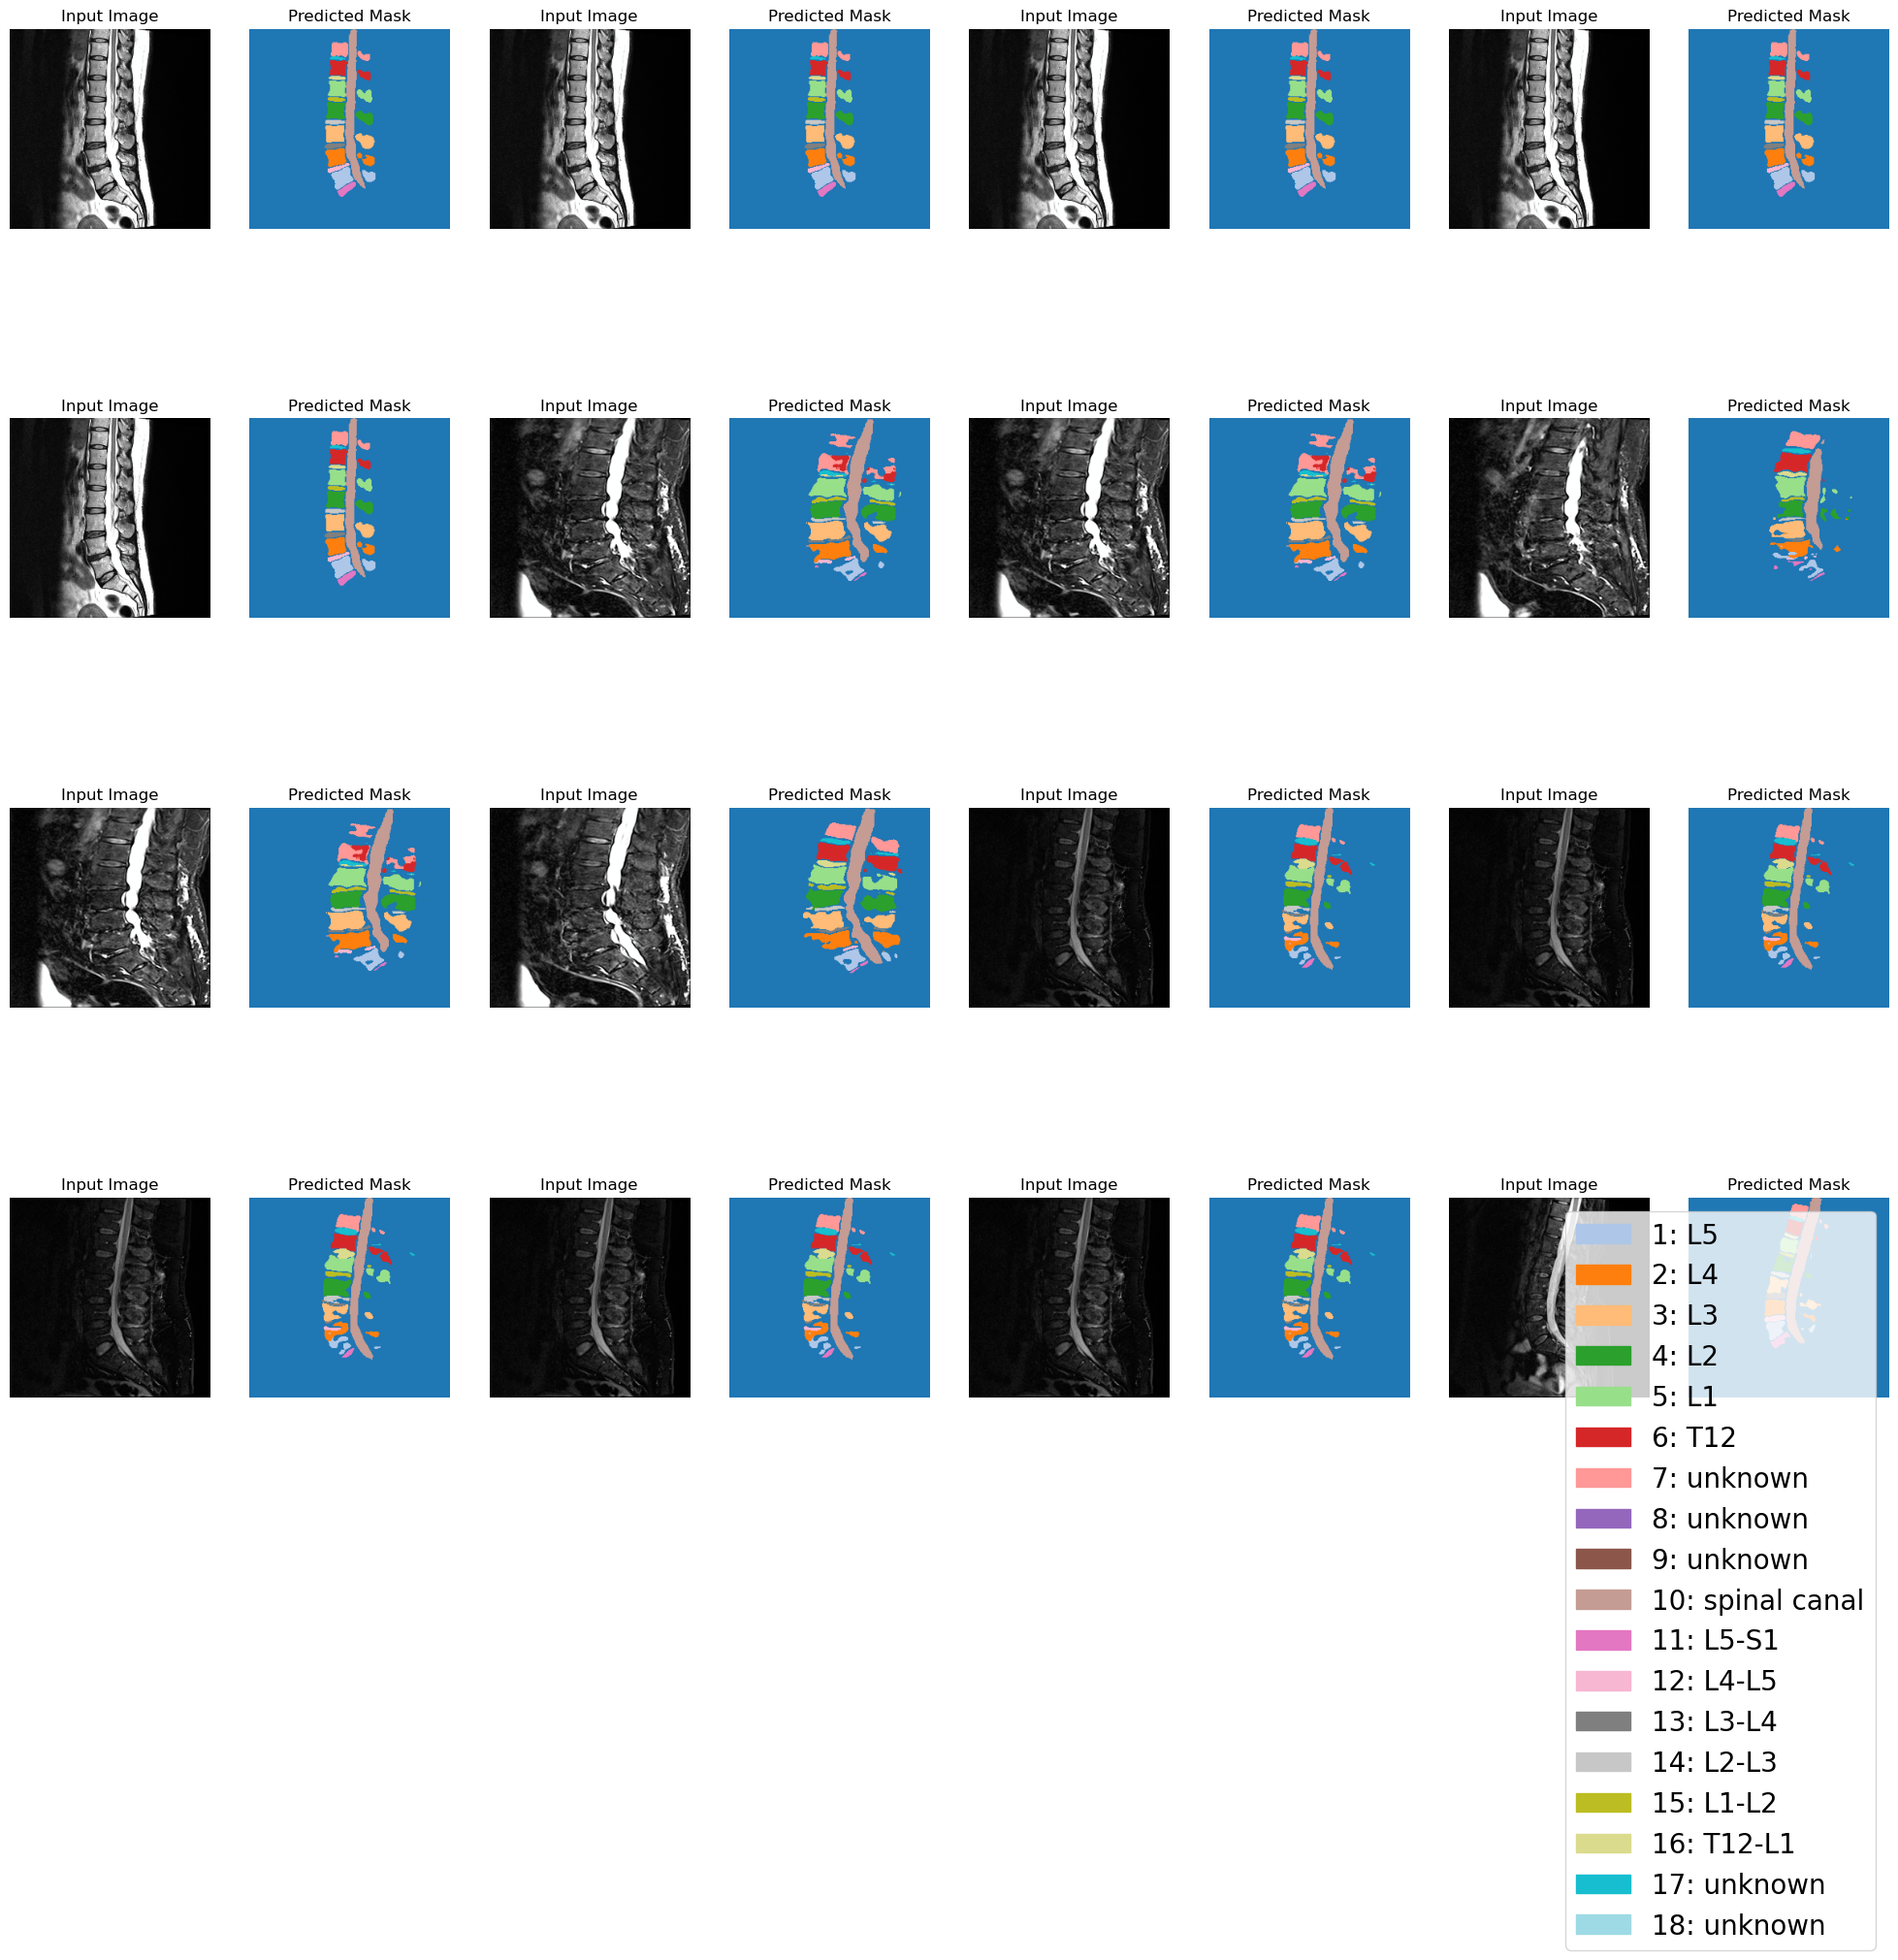

In [13]:
model.eval()
model.to(device)

rowId, images, masks = inference(model, val_loader, device, num_samples=16)
visualize_predictions(images, masks, num_samples=16)

# Test

In [149]:
def create_dataset(level):
    df = test.loc[test['level'] == level].reset_index(drop=True)
    dataset_valid = SEGDataset(df, 'valid',  transforms_valid)
    val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=20, shuffle=False, num_workers=num_workers, pin_memory=False)
    
    model.eval()
    model.to(device)
    rowId, images, masks = inference(model, val_loader, device, num_samples=len(df))
    crop_spine(images, masks, rowId, level=level, num_classes=20, num_samples=len(df))
#     rowId, images, masks = inference(model, val_loader, device, num_samples=16)
#     crop_spine(images, masks, rowId, level=level, num_classes=20, num_samples=16)

In [150]:
import matplotlib.image
import scipy.misc
def draw_rect(level, mask):
    level1 = level[0:2]
    level2 = level[-2:]
    disk1 = label_list.index(level1)
    if (level2!='S1'):
        disk2 = label_list.index(level2)
    else:
        disk2 = label_list.index(level[0:2] + '-'+level[-2:])
                             
    # for upper left corner
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
    color_mask[mask == disk1] = 1
    gray = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    x_min = 0
    x_max = mask.shape[0]
    y_min = sys.maxsize
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        y_min = y if y<y_min else y_min
                             
    # for lower right corner
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
    color_mask[mask == disk2] = 1
    gray = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    y_max = 0
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        y_max = y if y>y_max else y_max
    
    if (level2=='S1'):
        y_max *= 2
    
    return x_min, y_min, x_max, y_max
    

def crop_spine(images, masks, row_id, level, num_classes=19, num_samples=16):
    
    label_colors = get_label_colors(num_classes)
    
    for i in range(num_samples):
        mask = masks[i].numpy()
        x_min, y_min, x_max, y_max = draw_rect(level, mask)
        ### original image load and crop
        temp_path = test.loc[test['row_id']== row_id[i]]['image_path'].tolist()[0]
        img = pydicom.dcmread(temp_path)
        im = cv2.resize(img.pixel_array, (newsize[0], newsize[1]))
        # crop
        crop_im = im[y_min:y_max, x_min:x_max]
        # resize
        if(np.array(crop_im.shape).all()==0):
            pass
        else:
            crop_im = cv2.resize(crop_im,(224,100))
            saved_path = path+"/"+row_id[i]+".png"
            cv2.imwrite(saved_path, (crop_im).astype('float64'))
        
        '''
        im = images[i].numpy()
        im = np.transpose(im, (1, 2, 0)).copy() 
        #denormalize
        im = ((im * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])*255  
        
             
        # crop
        crop_im = im[y_min:y_max, x_min:x_max, :]
        

        # resize
        if(np.array(crop_im.shape).all()==0):
            pass
        else:
            crop_im = cv2.resize(crop_im,(224,100))
            saved_path = path+"/"+row_id[i]+".png"
            cv2.imwrite(saved_path, (crop_im*255.0).astype('uint8'))
        '''



False


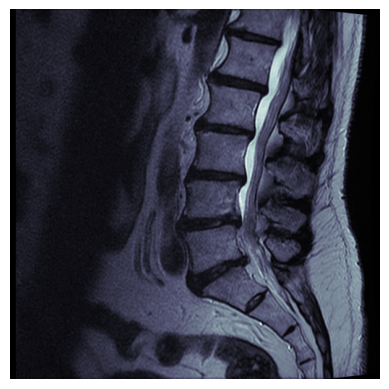

In [151]:
path = '/home/nova/Desktop/Nova/Segmentations/rsna-2024-lumbar-spine-degenerative-classification//train_images/3686953707/543025966/10.dcm'
image = pydicom.dcmread(path)
plt.imshow(image.pixel_array, cmap=plt.cm.bone)
print(np.array(image.pixel_array.shape).any()==0)
# plt.title(f"Image {i+1}")
# matplotlib.image.imsave('test.png', image)
plt.axis('off')
plt.show()

In [152]:
test = train_data.loc[(train_data['series_description'] == 'Sagittal T2/STIR')].reset_index(drop=True)
levels = test['level'].unique()
# new directory
path = '../segmented_disks1'
if not os.path.exists(path):
    os.makedirs(path)

# create_dataset(levels[-1])
for level in levels:
    print(level)
    create_dataset(level)


L1/L2
inference start
L2/L3
inference start
L3/L4
inference start
L4/L5
inference start
L5/S1
inference start


In [63]:
test.loc[test['row_id']=='3686953707_spinal_canal_stenosis_l4_l5']['image_path'].tolist()[0]

'/home/nova/Desktop/Nova/Segmentations/rsna-2024-lumbar-spine-degenerative-classification//train_images/3686953707/543025966/10.dcm'

In [ ]:
levels

In [ ]:
crop_spine(images, masks, level='L1/L2', num_classes=20, num_samples=16)

# References
I took most of the inspiration from the following notebooks
- https://www.kaggle.com/code/shubhamcodez/rsna-efficientnet-starter-notebook
- https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/
- https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/
- https://www.kaggle.com/code/anoukstein/2d-segmentation-of-sagittal-lumbar-spine-mri